# Kalman Filter Algorithm

        本节，我们就接触到了kalmanfilter，其实，在本节之前，我们已经领略到了KalmanFilter的基本思想和实施步骤，因此，本节将不再过多的介绍，直接给出相应的算法实施步骤，以及一个例子。
        

## Kalman Filter Algorithm

The algorithm is the same Bayesian filter algorithm that we have used in every chapter. The update step is slightly more complicated, but I will explain why when we get to it.

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use process model to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement
    
As a reminder, here is a graphical depiction of the algorithm:


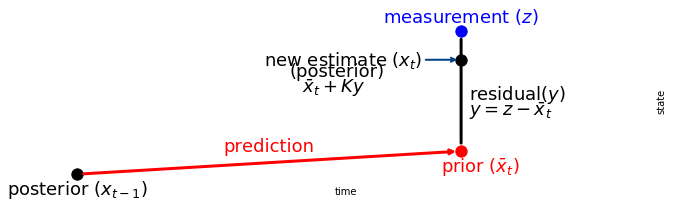

In [1]:
%matplotlib inline
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()


The univariate Kalman filter represented the state with a univariate Gaussian. Naturally the multivariate Kalman filter will use a multivariate Gaussian for the state. We learned in the last chapter that multivariate Gaussians use a vector for the mean and a matrix for the covariances. That means that the Kalman filter needs to use linear algebra to perform the estimations.

I don't want you to memorize these equations, but I have listed the univariate and multivariate equations below. They are quite similar.

<u>**Predict**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

Without worrying about the specifics of the linear algebra, we can see that:

$\mathbf x,\, \mathbf P$ are the state mean and covariance. They correspond to $x$ and $\sigma^2$.

$\mathbf F$ is the *state transition function*. When multiplied by $\bf x$ it computes the prior. 

$\mathbf Q$ is the process covariance. It corresponds to $\sigma^2_{f_x}$.

$\mathbf B$ and $\mathbf u$ are new to us. They let us model control inputs to the system.

<u>**Update**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ is the measurement function. We haven't seen this yet in this book and I'll explain it later. If you mentally remove $\mathbf H$ from the equations, you should be able to see these equations are similar as well.

$\mathbf z,\, \mathbf R$ are the measurement mean and noise covariance. They correspond to $z$ and $\sigma_z^2$ in the univariate filter (I've substituted $\mu$ with $x$ for the univariate equations to make the notation as similar as possible).

$\mathbf y$ and $\mathbf K$ are the residual and Kalman gain. 

The details will be different than the univariate filter because these are vectors and matrices, but the concepts are exactly the same: 

<ul>
    <li>Use a Gaussian to represent our estimate of the state and error<l/i>
    <li>Use a Gaussian to represent the measurement and its error<l/i>
    <li>Use a Gaussian to represent the process model<l/i>
    <li>Use the process model to predict the next state (the prior)<l/i>
    <li>Form an estimate part way between the measurement and the prior<l/i>
</ul>

Your job as a designer will be to design the state $\left(\mathbf x, \mathbf P\right)$, the process $\left(\mathbf F, \mathbf Q\right)$, the measurement $\left(\mathbf z, \mathbf R\right)$, and the  measurement function $\mathbf H$. If the system has control inputs, such as a robot, you will also design $\mathbf B$ and $\mathbf u$.


这个算法步骤，我是直接从原文中摘出来的，写的已经很详细了。我也将以图片形式给出我的笔记，如下：




## 例子
        接下来我们就上一道菜：
        

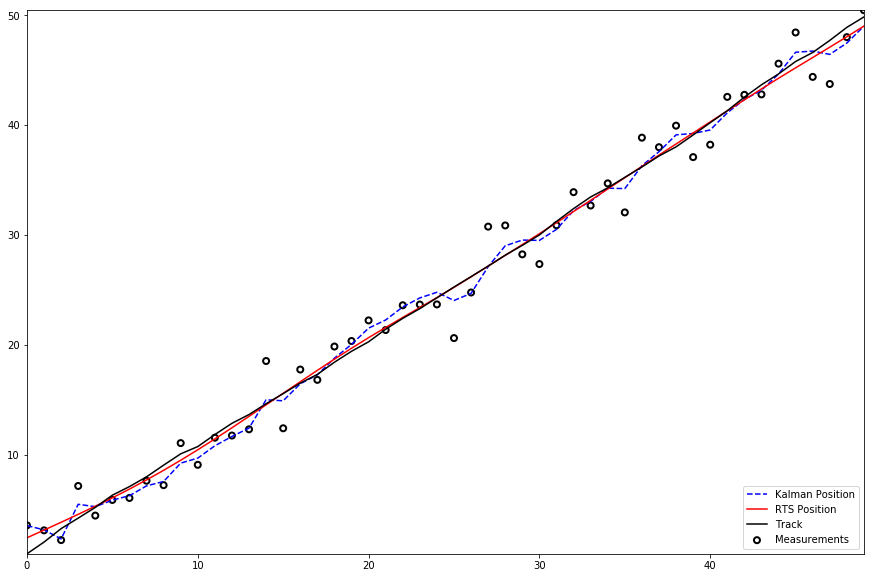

In [38]:
import math
from math import sqrt
import numpy as np
from numpy.random import randn
from numpy.random import seed
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from kf_book.book_plots import set_figsize, figsize


def pos_vel_filter(x, u, P, B, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=len(x), dim_u=len(x), dim_z=1)
    kf.x = np.array([x[0], x[1]]) # 位置和速度初值
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # 状态转移矩阵
    if np.isscalar(u):
        kf.u *= u
    else:
        kf.u = np.array([u[0], u[1]]) # 位置和速度输入
    kf.H = np.array([[1., 0]])    # 测量方程矩阵
    kf.R *= R                     # 测量不确定性
    if np.isscalar(P):            # 如果是标量
        kf.P *= P                 # 位置不确定性 
    else:
        kf.P[:] = P               # [:] makes deep copy
        
    if np.isscalar(B):
        kf.B *= B
    else:
        kf.B[:] = B              # 输入控制矩阵
        
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q) # 过程不确定性
    else:
        kf.Q[:] = Q
        
    return kf

def compute_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    
    x, vel = 0., 1.   # 真实初始状态
    z_std = sqrt(z_var)  # 测量不确定性标准差
    p_std = sqrt(process_var)  # 过程不确定性标准差
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std) # 测量速度
        x += v*dt                   # 测量位移
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)


count = 50  # 测量次数
seed(8923)

# 初始化
x = (0., 0.)
P = np.diag([500., 49.])
u = (0., 0.)
B = 0.
R = 3.
Q = 0.02

# 建立KalmanFilter，并获取测量值zs
f = pos_vel_filter(x=x, u=u, R=R, Q=Q, P=P, B=B)
track, zs = compute_data(R, Q, count)

# 进行滤波处理
Xs, Covs, _, _ = f.batch_filter(zs, us=u)       # 滤波处理
Ms, Ps, _ = f.rts_smoother(Xs, Covs)            # RTS平滑处理方法，这是经常使用的平滑处理器，此外还有，Fixed-Lag-Smoothing，后面会简单讲到。

# 绘图
with figsize(x=15, y=10):
    book_plots.plot_measurements(zs)
    plt.plot(Xs[:, 0], ls='--', label='Kalman Position', color='b')
    plt.plot(Ms[:, 0], label='RTS Position', color='r')
    plt.plot(track, label='Track', color='k')
    plt.legend(loc=4);

In [39]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/8kXK5dvdGQg" frameborder="0" allowfullscreen></iframe>')